In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import BaseCrossValidator
import matplotlib.pyplot as plt
import random
import optuna


In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
nasa_df = pd.read_csv('../Datasets/nasa_Interp_flat.csv')
nasa_df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,q_interp_0,q_interp_1,q_interp_2,q_interp_3,q_interp_4,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,B0047,2.0,0,1.674305,0.837152,1.709394,1.709394,1.709394,1.709394,1.709394,...,6.250255,6.250255,6.250255,6.250255,6.250255,6.250255,6.250255,6.250255,6.250255,6.250255
1,B0047,2.0,4,1.524366,0.762183,1.552095,1.552095,1.543988,1.531612,1.519237,...,5.454957,5.454957,5.454957,5.454957,5.454957,5.454957,5.454957,5.454957,5.454957,5.454957
2,B0047,2.0,6,1.508076,0.754038,1.535831,1.535831,1.535831,1.535831,1.533859,...,6.160903,6.160586,6.160270,6.159953,6.159636,6.159319,6.159002,6.158686,6.158369,6.145254
3,B0047,2.0,8,1.483558,0.741779,1.515224,1.515224,1.515224,1.515224,1.515224,...,4.579210,4.579005,4.578800,4.578595,4.578390,4.578184,4.577979,4.577774,4.577569,4.553269
4,B0047,2.0,10,1.467139,0.733570,1.498919,1.498919,1.497887,1.486999,1.476112,...,4.872190,4.872071,4.871953,4.871834,4.871715,4.871596,4.871478,4.871359,4.871240,4.826283


In [4]:
oxford_df = pd.read_csv('../Datasets/oxford_Interp_flat.csv')
oxford_df.head()

,cell_id,cycle_index,capacity,soh,voltage_raw,charge_raw,temperature_raw,time_raw,q_interp_0,q_interp_1,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,Cell1,0,0.739111,0.998799,"[4.1912351, 4.1757555, 4.1743121, 4.1726279, 4...","[-0.0, 0.0001948313260934485, 0.00039978834191...","[40.026463, 40.051395, 39.988987, 39.976521, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.720836,0.720900,...,39.970291,39.967860,39.965425,39.962987,39.960546,39.958101,39.955654,39.953203,39.950750,39.948294
1,Cell1,100,0.730193,0.986747,"[4.1926785, 4.1765175, 4.1749935, 4.1737504, 4...","[-0.0, 0.00019481252778942048, 0.0003997496296...","[39.964054, 39.8517, 39.876675, 39.914112, 39....","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.718104,0.718055,...,39.868830,39.868614,39.868491,39.868465,39.868536,39.868707,39.868979,39.869354,39.869834,39.870422
2,Cell1,200,0.725747,0.980739,"[4.1929593, 4.1769986, 4.1752744, 4.1739912, 4...","[-0.0, 0.00019479553618175448, 0.0003997179553...","[39.914112, 39.901646, 39.876675, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",0.716575,0.716481,...,39.842586,39.839024,39.835395,39.831697,39.827929,39.824091,39.820181,39.816198,39.812141,39.808010
3,Cell1,300,0.722843,0.976815,"[4.192502, 4.1766214, 4.1748571, 4.1732931, 4....","[-0.0, 0.000194722652140273, 0.000399565470333...","[39.926579, 39.876675, 39.976521, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",0.715259,0.715138,...,39.846698,39.843177,39.839596,39.835955,39.832253,39.828488,39.824659,39.820767,39.816809,39.812785
4,Cell1,400,0.718367,0.970766,"[4.1927824, 4.1767821, 4.1753383, 4.1738949, 4...","[-0.0, 0.00019478713911181032, 0.0003996975935...","[39.876675, 39.926579, 39.926579, 39.864166, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.713821,0.713647,...,39.870769,39.869795,39.868855,39.867950,39.867079,39.866243,39.865444,39.864681,39.863955,39.863266


In [5]:
isu_df = pd.read_csv('../Datasets/isu_Interp_flat.csv')
isu_df.rename(columns={'rpt_index': 'cycle_index'}, inplace=True)
isu_df.head()

,cell_id,cycle_index,capacity,soh,q_interp_0,q_interp_1,q_interp_2,q_interp_3,q_interp_4,q_interp_5,...,e_interp_990,e_interp_991,e_interp_992,e_interp_993,e_interp_994,e_interp_995,e_interp_996,e_interp_997,e_interp_998,e_interp_999
0,G1C1,0,0.280457,1.121826,0.280745,0.280712,0.280681,0.280649,0.280618,0.280587,...,0.001518,0.001288,0.001067,0.000856,0.000655,0.000464,0.000282,0.000111,-0.000050,-0.000201
1,G1C1,1,0.279856,1.119422,0.279864,0.279845,0.279826,0.279808,0.279789,0.279771,...,0.001168,0.000777,0.000388,0.000003,-0.000380,-0.000759,-0.001136,-0.001510,-0.001881,-0.002250
2,G1C1,2,0.278479,1.113917,0.278299,0.278290,0.278280,0.278270,0.278260,0.278250,...,0.001739,0.001386,0.001040,0.000701,0.000368,0.000042,-0.000277,-0.000589,-0.000895,-0.001195
3,G1C1,3,0.277190,1.108761,0.276854,0.276852,0.276850,0.276848,0.276845,0.276842,...,0.002239,0.001939,0.001650,0.001372,0.001105,0.000848,0.000603,0.000368,0.000145,-0.000067
4,G1C1,4,0.276860,1.107439,0.276685,0.276676,0.276666,0.276657,0.276647,0.276637,...,0.001882,0.001513,0.001151,0.000797,0.000451,0.000113,-0.000218,-0.000541,-0.000857,-0.001165


In [6]:
common_cols = [col for col in nasa_df.columns if col in oxford_df.columns and col in isu_df.columns]
common_cols = list(common_cols)

for i in range(0, len(common_cols), 10):
    print(', '.join(common_cols[i:i+10]))


cell_id, cycle_index, capacity, soh, q_interp_0, q_interp_1, q_interp_2, q_interp_3, q_interp_4, q_interp_5
q_interp_6, q_interp_7, q_interp_8, q_interp_9, q_interp_10, q_interp_11, q_interp_12, q_interp_13, q_interp_14, q_interp_15
q_interp_16, q_interp_17, q_interp_18, q_interp_19, q_interp_20, q_interp_21, q_interp_22, q_interp_23, q_interp_24, q_interp_25
q_interp_26, q_interp_27, q_interp_28, q_interp_29, q_interp_30, q_interp_31, q_interp_32, q_interp_33, q_interp_34, q_interp_35
q_interp_36, q_interp_37, q_interp_38, q_interp_39, q_interp_40, q_interp_41, q_interp_42, q_interp_43, q_interp_44, q_interp_45
q_interp_46, q_interp_47, q_interp_48, q_interp_49, q_interp_50, q_interp_51, q_interp_52, q_interp_53, q_interp_54, q_interp_55
q_interp_56, q_interp_57, q_interp_58, q_interp_59, q_interp_60, q_interp_61, q_interp_62, q_interp_63, q_interp_64, q_interp_65
q_interp_66, q_interp_67, q_interp_68, q_interp_69, q_interp_70, q_interp_71, q_interp_72, q_interp_73, q_interp_74, q_int

In [7]:
def merge_battery_datasets(datasets: dict):
    """
    Merge battery datasets with a 'source' column indicating origin.

    Args:
        datasets (dict): Dictionary of DataFrames with keys as source names.
                         Example: {'nasa': nasa_df, 'oxford': oxford_df}

    Returns:
        pd.DataFrame: Merged DataFrame with 'source' column
    """
    dfs = []
    for name, df in datasets.items():
        df_copy = df.copy()
        df_copy['source'] = name
        dfs.append(df_copy)

    return pd.concat(dfs, ignore_index=True)


In [8]:
df_merged = merge_battery_datasets({
    'nasa': nasa_df,
    'oxford': oxford_df,
    'isu': isu_df
})


In [9]:
missing = df_merged.isnull().sum()
missing = missing[missing > 0]
print(missing)


rated_capacity    5974
t_interp_0        5455
t_interp_1        5455
t_interp_2        5455
t_interp_3        5455
                  ... 
e_interp_995      3286
e_interp_996      3286
e_interp_997      3286
e_interp_998      3286
e_interp_999      3286
Length: 2005, dtype: int64


In [10]:
# ============================
# Sequence Builder
# ============================
def build_rnn_sequences(df, feature_cols, target_col='soh'):
    X_seq, y_seq = {}, {}
    for cell_id in df['cell_id'].unique():
        df_cell = df[df['cell_id'] == cell_id].sort_values('cycle_index')
        X_seq[cell_id] = df_cell[feature_cols].values.astype(np.float32)
        y_seq[cell_id] = df_cell[target_col].values.astype(np.float32)
    return X_seq, y_seq

In [11]:
# ============================
# Dataset for LSTM
# ============================
class BatterySeqDataset(Dataset):
    def __init__(self, X_seq_dict, y_seq_dict):
        self.X = list(X_seq_dict.values())
        self.y = list(y_seq_dict.values())
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])


In [12]:
# ============================
# LSTM Model
# ============================
class BatteryRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, output_dim=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1]) 

In [13]:
# ============================
# Cross Validator
# ============================
class BatteryWiseSplit(BaseCrossValidator):
    def __init__(self, n_splits=5, random_state=None, column_group='source'):
        self.n_splits = n_splits
        self.random_state = random_state
        self.column_group = column_group
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    def split(self, X, y=None, groups=None):
        df = X.copy()
        if 'cell_id' not in df.columns or self.column_group not in df.columns:
            raise ValueError("DataFrame must contain 'cell_id' and column group.")
        rng = np.random.RandomState(self.random_state)
        unique_batteries = df[["cell_id", self.column_group]].drop_duplicates()
        batteries_by_source = unique_batteries.groupby(self.column_group)["cell_id"].apply(list)
        folds = [[] for _ in range(self.n_splits)]
        for source, battery_list in batteries_by_source.items():
            rng.shuffle(battery_list)
            for i, cell_id in enumerate(battery_list):
                folds[i % self.n_splits].append(cell_id)
        for i in range(self.n_splits):
            val_batteries = set(folds[i])
            train_batteries = set(unique_batteries["cell_id"]) - val_batteries
            train_idx = df[df["cell_id"].isin(train_batteries)].index.values
            val_idx = df[df["cell_id"].isin(val_batteries)].index.values
            yield train_idx, val_idx

In [14]:
# ============================
# Trainer Class
# ============================
class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100, normalize=True, verbose=True):
        self.df = df.copy()
        self.target_cols = target_cols
        self.verbose = verbose
        if 'source' not in self.df.columns:
            self.df['source'] = self.df['cell_id'].apply(self._infer_source)
        if normalize:
            self.df = self.normalize_per_source(self.df)
        q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
        i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
        self.feature_cols = q_cols + i_cols + ['cycle_index']
        self._prepare_data()
    def _infer_source(self, cell_id):
        if str(cell_id).startswith('B'):
            return 'nasa'
        elif str(cell_id).startswith('Cell'):
            return 'oxford'
        elif str(cell_id).startswith('G'):
            return 'isu'
        else:
            return 'unknown'
        
    def normalize_per_source(self, df, exclude_cols=['capacity', 'soh']):
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        columns_base = [col for col in numeric_cols if col not in exclude_cols]
        normalized_data = []
        for src in df['source'].unique():
            sub_df = df[df['source'] == src].copy()
            columns_to_normalize = [col for col in columns_base if sub_df[col].isna().mean() < 0.5]
            if sub_df[columns_to_normalize].dropna().shape[0] == 0:
                print(f" Skipping source={src} — all NaNs in features")
                continue
            for col in columns_to_normalize:
                sub_df[col] = sub_df[col].fillna(sub_df[col].mean())
            try:
                scaler = StandardScaler()
                sub_df[columns_to_normalize] = scaler.fit_transform(sub_df[columns_to_normalize])
                normalized_data.append(sub_df)
                if self.verbose:
                    print(f" Normalized source={src} with {len(columns_to_normalize)} features")
            except Exception as e:
                print(f" Skipping source={src} due to error: {e}")
        if not normalized_data:
            raise ValueError("No valid groups found during normalization. Check for missing data or too many NaNs.")
        return pd.concat(normalized_data, ignore_index=True)
    
    
    def _prepare_data(self):
        splitter = BatteryWiseSplit(n_splits=5, random_state=42, column_group='source')
        self.df = self.df.reset_index(drop=True)
        train_idx, test_idx = next(splitter.split(self.df))
        self.train_idx = train_idx
        self.test_idx = test_idx
        train_df = self.df.iloc[train_idx].copy()
        test_df = self.df.iloc[test_idx].copy()
        self.scaler = StandardScaler()
        self.scaler.fit(train_df[self.feature_cols])
        train_df[self.feature_cols] = self.scaler.transform(train_df[self.feature_cols])
        test_df[self.feature_cols] = self.scaler.transform(test_df[self.feature_cols])
        X_train_seq, y_train_seq = build_rnn_sequences(train_df, self.feature_cols, self.target_cols[0])
        X_test_seq, y_test_seq = build_rnn_sequences(test_df, self.feature_cols, self.target_cols[0])
        self.train_loader = DataLoader(BatterySeqDataset(X_train_seq, y_train_seq), batch_size=1, shuffle=True)
        self.val_loader = DataLoader(BatterySeqDataset(X_test_seq, y_test_seq), batch_size=1)
    
    def train(self, epochs=20, lr=1e-3):
        self.model = BatteryRNN(input_dim=len(self.feature_cols), output_dim=1)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        self.train_mse, self.val_mse = [], []
        self.train_mae, self.val_mae = [], []
        self.train_r2, self.val_r2 = [], []
        for epoch in range(epochs):
            self.model.train()
            preds, targets = [], []
            for xb, yb in self.train_loader:
                pred = self.model(xb).squeeze(-1)
                loss = criterion(pred, yb[:, -1])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                preds.append(pred.detach().numpy())
                targets.append(yb[:, -1].numpy())
            preds = np.concatenate(preds)
            targets = np.concatenate(targets)
            self.train_mse.append(mean_squared_error(targets, preds))
            self.train_mae.append(mean_absolute_error(targets, preds))
            self.train_r2.append(r2_score(targets, preds))
            
            self.model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for xb, yb in self.val_loader:
                    pred = self.model(xb).squeeze(-1)
                    val_preds.append(pred.numpy())
                    val_targets.append(yb[:, -1].numpy())
            val_preds = np.concatenate(val_preds)
            val_targets = np.concatenate(val_targets)
            self.val_mse.append(mean_squared_error(val_targets, val_preds))
            self.val_mae.append(mean_absolute_error(val_targets, val_preds))
            self.val_r2.append(r2_score(val_targets, val_preds))
            
            print(f"Epoch {epoch+1}: Train MSE={self.train_mse[-1]:.4f}, Val MSE={self.val_mse[-1]:.4f}")
            print(f"Train MAE={self.train_mae[-1]:.4f}, Val MAE={self.val_mae[-1]:.4f}")
            print(f"Train R²={self.train_r2[-1]:.4f}, Val R²={self.val_r2[-1]:.4f}")


    def plot_metrics(self):
        epochs = range(1, len(self.train_mse) + 1)

        print(f"Length of epochs: {len(epochs)}")
        print(f"Length of train_mse: {len(self.train_mse)}")
        print(f"Length of val_mse: {len(self.val_mse)}")
        print(f"Length of train_mae: {len(self.train_mae)}")
        print(f"Length of val_mae: {len(self.val_mae)}")
        print(f"Length of train_r2: {len(self.train_r2)}")
        print(f"Length of val_r2: {len(self.val_r2)}")

        plt.figure()
        plt.plot(epochs, self.train_mse, label="Train MSE")
        plt.plot(epochs, self.val_mse, label="Val MSE")
        plt.title("MSE vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(epochs, self.train_mae, label="Train MAE")
        plt.plot(epochs, self.val_mae, label="Val MAE")
        plt.title("MAE vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(epochs, self.train_r2, label="Train R²")
        plt.plot(epochs, self.val_r2, label="Val R²")
        plt.title("R² vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("R²")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_split_distribution(self):
        import numpy as np
        df_train = self.df.iloc[self.train_idx]
        df_test = self.df.iloc[self.test_idx]

        train_counts = df_train['cell_id'].value_counts().sort_index()
        test_counts = df_test['cell_id'].value_counts().sort_index()
        all_cell_ids = sorted(set(self.df['cell_id']))
        train_vals = [train_counts.get(cid, 0) for cid in all_cell_ids]
        test_vals = [test_counts.get(cid, 0) for cid in all_cell_ids]

        y = np.arange(len(all_cell_ids))
        height = 0.4

        plt.figure(figsize=(10, max(6, len(all_cell_ids) * 0.2)))
        plt.barh(y, train_vals, height=height, label='Train', alpha=0.7)
        plt.barh(y + height, test_vals, height=height, label='Test', alpha=0.7)
        plt.yticks(y + height / 2, all_cell_ids, fontsize=6)
        plt.ylabel('Battery ID')
        plt.xlabel('Cycle Count')
        plt.title('Train/Test Split by Battery ID')
        plt.legend()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [15]:
trainer = BatteryTrainer(df_merged, target_cols=['capacity'])


 Normalized source=nasa with 3002 features
 Normalized source=oxford with 3001 features
 Normalized source=isu with 3001 features


Epoch 1: Train MSE=0.3161, Val MSE=0.4858
Train MAE=0.3320, Val MAE=0.5158
Train R²=-1.2752, Val R²=-2.0394
Epoch 2: Train MSE=0.1372, Val MSE=0.1524
Train MAE=0.1953, Val MAE=0.1951
Train R²=0.0128, Val R²=0.0466
Epoch 3: Train MSE=0.1158, Val MSE=0.1667
Train MAE=0.1801, Val MAE=0.3187
Train R²=0.1663, Val R²=-0.0432
Epoch 4: Train MSE=0.0836, Val MSE=0.0930
Train MAE=0.1708, Val MAE=0.1411
Train R²=0.3984, Val R²=0.4180
Epoch 5: Train MSE=0.0673, Val MSE=0.0867
Train MAE=0.1510, Val MAE=0.1549
Train R²=0.5156, Val R²=0.4574
Epoch 6: Train MSE=0.0463, Val MSE=0.0875
Train MAE=0.1267, Val MAE=0.1493
Train R²=0.6664, Val R²=0.4524
Epoch 7: Train MSE=0.0326, Val MSE=0.1245
Train MAE=0.1082, Val MAE=0.1627
Train R²=0.7651, Val R²=0.2212
Epoch 8: Train MSE=0.0372, Val MSE=0.0494
Train MAE=0.1135, Val MAE=0.1149
Train R²=0.7323, Val R²=0.6910
Epoch 9: Train MSE=0.0224, Val MSE=0.0407
Train MAE=0.1002, Val MAE=0.0979
Train R²=0.8386, Val R²=0.7452
Epoch 10: Train MSE=0.0297, Val MSE=0.0933


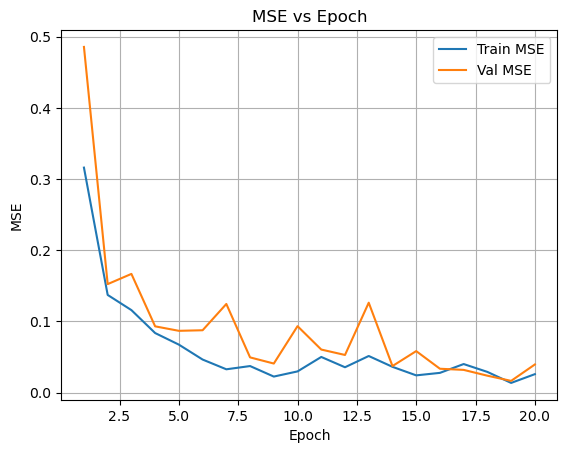

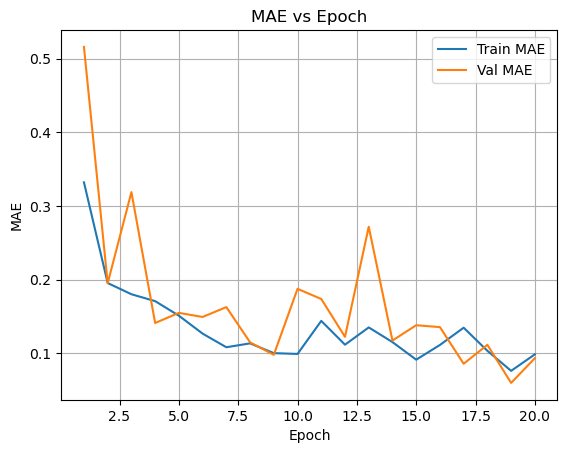

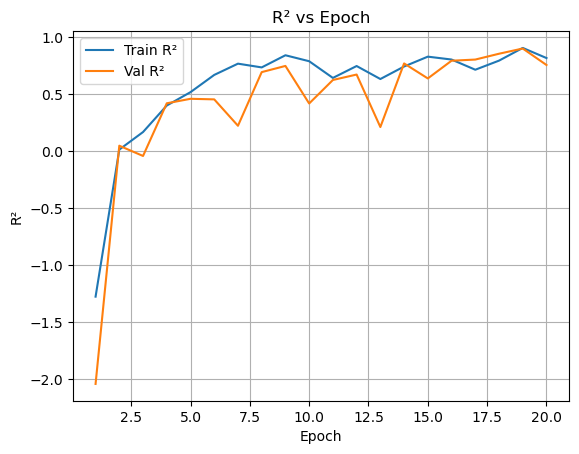

In [16]:
trainer.train(epochs=20)
trainer.plot_metrics()


In [17]:
model = BatteryRNN(input_dim=10)  # replace with your actual input_dim

for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


rnn.weight_ih_l0: torch.Size([128, 10])
rnn.weight_hh_l0: torch.Size([128, 128])
rnn.bias_ih_l0: torch.Size([128])
rnn.bias_hh_l0: torch.Size([128])
fc.weight: torch.Size([1, 128])
fc.bias: torch.Size([1])


In [18]:
print(f"\nFinal Train R²: {trainer.train_r2[-1]:.4f}")
print(f"Final Val R²:   {trainer.val_r2[-1]:.4f}")



Final Train R²: 0.8143
Final Val R²:   0.7534


In [25]:
# ============================
# Optuna Objective Function with Cross-Validation
# ============================
def rnn_optuna_objective_existing(trial, df, target_cols):
    hidden_dim = trial.suggest_categorical("hidden_dim", [128])
    num_layers = trial.suggest_int("num_layers", 1, 2, 8)
    dropout = trial.suggest_float("dropout", 0.0, 0.1)

    from sklearn.model_selection import KFold

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_r2_scores = []

    for train_index, test_index in kf.split(df['cell_id'].unique()):
        train_cells = df['cell_id'].unique()[train_index]
        test_cells = df['cell_id'].unique()[test_index]

        train_df = df[df['cell_id'].isin(train_cells)].copy()
        test_df = df[df['cell_id'].isin(test_cells)].copy()

        trainer = BatteryTrainer(
            df=pd.concat([train_df, test_df], ignore_index=True),  # combined to preserve full preprocessing
            target_cols=target_cols,
            max_q=100,
            max_i=100,
            normalize=True,
            verbose=False
        )

        trainer.model = nn.RNN(
            input_size=len(trainer.feature_cols),
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        trainer.train(epochs=10)
        val_r2_scores.append(trainer.val_r2[-1])

    return np.mean(val_r2_scores)

def run_optuna_tuning(df, target_cols, n_trials=10):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: rnn_optuna_objective_existing(trial, df, target_cols), n_trials=n_trials)

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  R²: {trial.value:.4f}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Visualize right away (optional)
    plt.figure()
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.grid(True)
    plt.show()

    plt.figure()
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Hyperparameter Importances")
    plt.grid(True)
    plt.show()

    return study


[I 2025-04-12 23:45:41,611] A new study created in memory with name: no-name-f613e4e5-2662-4ac1-ac49-9fbb337bea46
C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.3001, Val MSE=0.1274
Train MAE=0.3358, Val MAE=0.1799
Train R²=-1.0406, Val R²=0.0075
Epoch 2: Train MSE=0.1453, Val MSE=0.1666
Train MAE=0.2113, Val MAE=0.2766
Train R²=0.0118, Val R²=-0.2981
Epoch 3: Train MSE=0.0869, Val MSE=0.0703
Train MAE=0.1795, Val MAE=0.1543
Train R²=0.4094, Val R²=0.4521
Epoch 4: Train MSE=0.0909, Val MSE=0.0823
Train MAE=0.1667, Val MAE=0.1751
Train R²=0.3821, Val R²=0.3590
Epoch 5: Train MSE=0.0541, Val MSE=0.0602
Train MAE=0.1344, Val MAE=0.1841
Train R²=0.6318, Val R²=0.5307
Epoch 6: Train MSE=0.0584, Val MSE=0.0681
Train MAE=0.1503, Val MAE=0.1487
Train R²=0.6028, Val R²=0.4690
Epoch 7: Train MSE=0.0457, Val MSE=0.0798
Train MAE=0.1277, Val MAE=0.1739
Train R²=0.6893, Val R²=0.3781
Epoch 8: Train MSE=0.0426, Val MSE=0.0366
Train MAE=0.1241, Val MAE=0.1610
Train R²=0.7105, Val R²=0.7145
Epoch 9: Train MSE=0.0289, Val MSE=0.0205
Train MAE=0.1097, Val MAE=0.0955
Train R²=0.8036, Val R²=0.8405
Epoch 10: Train MSE=0.0268, Val MSE=0.0346
T

[I 2025-04-12 23:46:19,571] Trial 0 finished with value: 0.4154942035675049 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.006876684327401007}. Best is trial 0 with value: 0.4154942035675049.


Epoch 10: Train MSE=0.0307, Val MSE=0.1169
Train MAE=0.1168, Val MAE=0.1487
Train R²=0.7806, Val R²=0.2481


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2599, Val MSE=0.3059
Train MAE=0.3008, Val MAE=0.3994
Train R²=-0.7669, Val R²=-1.3838
Epoch 2: Train MSE=0.1743, Val MSE=0.1243
Train MAE=0.2293, Val MAE=0.1704
Train R²=-0.1850, Val R²=0.0315
Epoch 3: Train MSE=0.1112, Val MSE=0.1285
Train MAE=0.1966, Val MAE=0.2414
Train R²=0.2439, Val R²=-0.0013
Epoch 4: Train MSE=0.0703, Val MSE=0.0357
Train MAE=0.1582, Val MAE=0.1134
Train R²=0.5221, Val R²=0.7218
Epoch 5: Train MSE=0.0590, Val MSE=0.0417
Train MAE=0.1509, Val MAE=0.0917
Train R²=0.5988, Val R²=0.6747
Epoch 6: Train MSE=0.0493, Val MSE=0.0745
Train MAE=0.1288, Val MAE=0.1132
Train R²=0.6650, Val R²=0.4196
Epoch 7: Train MSE=0.0478, Val MSE=0.0651
Train MAE=0.1224, Val MAE=0.1407
Train R²=0.6752, Val R²=0.4930
Epoch 8: Train MSE=0.0410, Val MSE=0.0710
Train MAE=0.1407, Val MAE=0.1743
Train R²=0.7215, Val R²=0.4470
Epoch 9: Train MSE=0.0494, Val MSE=0.0415
Train MAE=0.1455, Val MAE=0.1074
Train R²=0.6641, Val R²=0.6765
Epoch 10: Train MSE=0.0332, Val MSE=0.0700

[I 2025-04-12 23:46:57,555] Trial 1 finished with value: 0.5450843373934428 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0527024223239739}. Best is trial 1 with value: 0.5450843373934428.


Epoch 10: Train MSE=0.0483, Val MSE=0.0613
Train MAE=0.1270, Val MAE=0.1557
Train R²=0.6550, Val R²=0.6058


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2687, Val MSE=0.2461
Train MAE=0.2946, Val MAE=0.2870
Train R²=-0.8267, Val R²=-0.9180
Epoch 2: Train MSE=0.1694, Val MSE=0.1146
Train MAE=0.2316, Val MAE=0.1959
Train R²=-0.1520, Val R²=0.1070
Epoch 3: Train MSE=0.1378, Val MSE=0.1509
Train MAE=0.2096, Val MAE=0.1798
Train R²=0.0629, Val R²=-0.1757
Epoch 4: Train MSE=0.0905, Val MSE=0.1015
Train MAE=0.1642, Val MAE=0.2014
Train R²=0.3844, Val R²=0.2091
Epoch 5: Train MSE=0.0585, Val MSE=0.0380
Train MAE=0.1508, Val MAE=0.1116
Train R²=0.6021, Val R²=0.7041
Epoch 6: Train MSE=0.0535, Val MSE=0.0601
Train MAE=0.1452, Val MAE=0.1173
Train R²=0.6359, Val R²=0.5319
Epoch 7: Train MSE=0.0425, Val MSE=0.0461
Train MAE=0.1187, Val MAE=0.1107
Train R²=0.7110, Val R²=0.6403
Epoch 8: Train MSE=0.0274, Val MSE=0.0381
Train MAE=0.1020, Val MAE=0.1440
Train R²=0.8140, Val R²=0.7032
Epoch 9: Train MSE=0.0410, Val MSE=0.0360
Train MAE=0.1245, Val MAE=0.1077
Train R²=0.7211, Val R²=0.7191
Epoch 10: Train MSE=0.0294, Val MSE=0.0636

[I 2025-04-12 23:47:36,438] Trial 2 finished with value: 0.4478877782821655 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.04142898484208051}. Best is trial 1 with value: 0.5450843373934428.


Epoch 10: Train MSE=0.0242, Val MSE=0.1171
Train MAE=0.0892, Val MAE=0.1860
Train R²=0.8275, Val R²=0.2464


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2807, Val MSE=0.1252
Train MAE=0.2979, Val MAE=0.1644
Train R²=-0.9085, Val R²=0.0240
Epoch 2: Train MSE=0.1364, Val MSE=0.1027
Train MAE=0.2169, Val MAE=0.2129
Train R²=0.0724, Val R²=0.2000
Epoch 3: Train MSE=0.0827, Val MSE=0.1383
Train MAE=0.1728, Val MAE=0.1565
Train R²=0.4375, Val R²=-0.0779
Epoch 4: Train MSE=0.0915, Val MSE=0.0683
Train MAE=0.1623, Val MAE=0.1625
Train R²=0.3777, Val R²=0.4677
Epoch 5: Train MSE=0.0749, Val MSE=0.1802
Train MAE=0.1534, Val MAE=0.2235
Train R²=0.4911, Val R²=-0.4041
Epoch 6: Train MSE=0.0597, Val MSE=0.0467
Train MAE=0.1478, Val MAE=0.1009
Train R²=0.5938, Val R²=0.6359
Epoch 7: Train MSE=0.0725, Val MSE=0.0520
Train MAE=0.1464, Val MAE=0.1421
Train R²=0.5073, Val R²=0.5944
Epoch 8: Train MSE=0.0592, Val MSE=0.0503
Train MAE=0.1511, Val MAE=0.1255
Train R²=0.5978, Val R²=0.6079
Epoch 9: Train MSE=0.0359, Val MSE=0.0400
Train MAE=0.1137, Val MAE=0.1296
Train R²=0.7560, Val R²=0.6884
Epoch 10: Train MSE=0.0321, Val MSE=0.0411


[I 2025-04-12 23:48:14,678] Trial 3 finished with value: 0.5556505918502808 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.029927641803747886}. Best is trial 3 with value: 0.5556505918502808.


Epoch 10: Train MSE=0.0383, Val MSE=0.0685
Train MAE=0.1190, Val MAE=0.1162
Train R²=0.7266, Val R²=0.5591


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2693, Val MSE=0.3184
Train MAE=0.2988, Val MAE=0.4719
Train R²=-0.8309, Val R²=-1.4816
Epoch 2: Train MSE=0.1732, Val MSE=0.1076
Train MAE=0.2491, Val MAE=0.1851
Train R²=-0.1776, Val R²=0.1613
Epoch 3: Train MSE=0.1150, Val MSE=0.0803
Train MAE=0.1947, Val MAE=0.1541
Train R²=0.2181, Val R²=0.3739
Epoch 4: Train MSE=0.1008, Val MSE=0.0461
Train MAE=0.1554, Val MAE=0.1048
Train R²=0.3145, Val R²=0.6405
Epoch 5: Train MSE=0.0525, Val MSE=0.0447
Train MAE=0.1261, Val MAE=0.1019
Train R²=0.6427, Val R²=0.6516
Epoch 6: Train MSE=0.0367, Val MSE=0.0469
Train MAE=0.1111, Val MAE=0.1515
Train R²=0.7503, Val R²=0.6344
Epoch 7: Train MSE=0.0372, Val MSE=0.0321
Train MAE=0.1167, Val MAE=0.1038
Train R²=0.7471, Val R²=0.7498
Epoch 8: Train MSE=0.0461, Val MSE=0.0638
Train MAE=0.1313, Val MAE=0.2201
Train R²=0.6868, Val R²=0.5030
Epoch 9: Train MSE=0.0369, Val MSE=0.0493
Train MAE=0.1164, Val MAE=0.1333
Train R²=0.7493, Val R²=0.6159
Epoch 10: Train MSE=0.0265, Val MSE=0.0242


[I 2025-04-12 23:48:54,172] Trial 4 finished with value: 0.531804362932841 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.060183039374607394}. Best is trial 3 with value: 0.5556505918502808.


Epoch 10: Train MSE=0.0296, Val MSE=0.0633
Train MAE=0.1059, Val MAE=0.1571
Train R²=0.7889, Val R²=0.5927


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2665, Val MSE=0.1041
Train MAE=0.3097, Val MAE=0.2192
Train R²=-0.8120, Val R²=0.1889
Epoch 2: Train MSE=0.1400, Val MSE=0.1207
Train MAE=0.2086, Val MAE=0.1650
Train R²=0.0483, Val R²=0.0595
Epoch 3: Train MSE=0.0869, Val MSE=0.0719
Train MAE=0.1634, Val MAE=0.1646
Train R²=0.4091, Val R²=0.4396
Epoch 4: Train MSE=0.1205, Val MSE=0.0560
Train MAE=0.1929, Val MAE=0.1670
Train R²=0.1807, Val R²=0.5633
Epoch 5: Train MSE=0.0603, Val MSE=0.0567
Train MAE=0.1484, Val MAE=0.1361
Train R²=0.5901, Val R²=0.5578
Epoch 6: Train MSE=0.0490, Val MSE=0.0461
Train MAE=0.1339, Val MAE=0.1798
Train R²=0.6667, Val R²=0.6409
Epoch 7: Train MSE=0.0391, Val MSE=0.0615
Train MAE=0.1295, Val MAE=0.1237
Train R²=0.7339, Val R²=0.5210
Epoch 8: Train MSE=0.0350, Val MSE=0.0223
Train MAE=0.1185, Val MAE=0.0728
Train R²=0.7619, Val R²=0.8265
Epoch 9: Train MSE=0.0176, Val MSE=0.0790
Train MAE=0.0822, Val MAE=0.1723
Train R²=0.8801, Val R²=0.3846
Epoch 10: Train MSE=0.0635, Val MSE=0.0277
Tr

[I 2025-04-12 23:49:35,667] Trial 5 finished with value: 0.6209726532300314 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.011504119836141925}. Best is trial 5 with value: 0.6209726532300314.


Epoch 10: Train MSE=0.0428, Val MSE=0.0387
Train MAE=0.1299, Val MAE=0.1179
Train R²=0.6944, Val R²=0.7512


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.3443, Val MSE=0.2641
Train MAE=0.3447, Val MAE=0.3224
Train R²=-1.3413, Val R²=-1.0582
Epoch 2: Train MSE=0.1794, Val MSE=0.0843
Train MAE=0.2369, Val MAE=0.1755
Train R²=-0.2196, Val R²=0.3430
Epoch 3: Train MSE=0.1107, Val MSE=0.1476
Train MAE=0.2027, Val MAE=0.3019
Train R²=0.2472, Val R²=-0.1501
Epoch 4: Train MSE=0.1029, Val MSE=0.0974
Train MAE=0.1988, Val MAE=0.1928
Train R²=0.3003, Val R²=0.2408
Epoch 5: Train MSE=0.0507, Val MSE=0.1599
Train MAE=0.1360, Val MAE=0.1729
Train R²=0.6551, Val R²=-0.2458
Epoch 6: Train MSE=0.0656, Val MSE=0.0497
Train MAE=0.1409, Val MAE=0.0992
Train R²=0.5541, Val R²=0.6128
Epoch 7: Train MSE=0.0378, Val MSE=0.0813
Train MAE=0.1224, Val MAE=0.1791
Train R²=0.7428, Val R²=0.3665
Epoch 8: Train MSE=0.0431, Val MSE=0.0478
Train MAE=0.1314, Val MAE=0.1098
Train R²=0.7068, Val R²=0.6272
Epoch 9: Train MSE=0.0345, Val MSE=0.0452
Train MAE=0.1134, Val MAE=0.1038
Train R²=0.7654, Val R²=0.6476
Epoch 10: Train MSE=0.0288, Val MSE=0.039

[I 2025-04-12 23:50:15,150] Trial 6 finished with value: 0.5702318350474039 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.02893007712933454}. Best is trial 5 with value: 0.6209726532300314.


Epoch 10: Train MSE=0.0360, Val MSE=0.0605
Train MAE=0.1116, Val MAE=0.1232
Train R²=0.7427, Val R²=0.6110


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2591, Val MSE=0.1456
Train MAE=0.2843, Val MAE=0.2655
Train R²=-0.7616, Val R²=-0.1343
Epoch 2: Train MSE=0.1462, Val MSE=0.1434
Train MAE=0.2283, Val MAE=0.1793
Train R²=0.0060, Val R²=-0.1175
Epoch 3: Train MSE=0.1578, Val MSE=0.0843
Train MAE=0.2103, Val MAE=0.1187
Train R²=-0.0727, Val R²=0.3431
Epoch 4: Train MSE=0.0959, Val MSE=0.1073
Train MAE=0.1730, Val MAE=0.1610
Train R²=0.3481, Val R²=0.1636
Epoch 5: Train MSE=0.0697, Val MSE=0.0573
Train MAE=0.1505, Val MAE=0.1146
Train R²=0.5263, Val R²=0.5531
Epoch 6: Train MSE=0.0548, Val MSE=0.0760
Train MAE=0.1273, Val MAE=0.1732
Train R²=0.6276, Val R²=0.4074
Epoch 7: Train MSE=0.0396, Val MSE=0.0589
Train MAE=0.1239, Val MAE=0.1042
Train R²=0.7305, Val R²=0.5407
Epoch 8: Train MSE=0.0282, Val MSE=0.0570
Train MAE=0.0989, Val MAE=0.1398
Train R²=0.8084, Val R²=0.5556
Epoch 9: Train MSE=0.0438, Val MSE=0.0650
Train MAE=0.1173, Val MAE=0.1375
Train R²=0.7023, Val R²=0.4932
Epoch 10: Train MSE=0.0551, Val MSE=0.0366

[I 2025-04-12 23:50:56,569] Trial 7 finished with value: 0.4388302167256673 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0524319061026357}. Best is trial 5 with value: 0.6209726532300314.


Epoch 10: Train MSE=0.0444, Val MSE=0.0993
Train MAE=0.1328, Val MAE=0.2567
Train R²=0.6828, Val R²=0.3609


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2447, Val MSE=0.1610
Train MAE=0.2932, Val MAE=0.2789
Train R²=-0.6640, Val R²=-0.2546
Epoch 2: Train MSE=0.0967, Val MSE=0.1196
Train MAE=0.1901, Val MAE=0.2195
Train R²=0.3424, Val R²=0.0677
Epoch 3: Train MSE=0.0837, Val MSE=0.1399
Train MAE=0.1800, Val MAE=0.2667
Train R²=0.4306, Val R²=-0.0901
Epoch 4: Train MSE=0.1001, Val MSE=0.0720
Train MAE=0.1660, Val MAE=0.2246
Train R²=0.3194, Val R²=0.4388
Epoch 5: Train MSE=0.0641, Val MSE=0.1080
Train MAE=0.1425, Val MAE=0.1848
Train R²=0.5642, Val R²=0.1580
Epoch 6: Train MSE=0.0488, Val MSE=0.0476
Train MAE=0.1255, Val MAE=0.1021
Train R²=0.6681, Val R²=0.6290
Epoch 7: Train MSE=0.0414, Val MSE=0.0541
Train MAE=0.1148, Val MAE=0.1094
Train R²=0.7182, Val R²=0.5785
Epoch 8: Train MSE=0.0634, Val MSE=0.0878
Train MAE=0.1528, Val MAE=0.1470
Train R²=0.5688, Val R²=0.3156
Epoch 9: Train MSE=0.0479, Val MSE=0.0447
Train MAE=0.1375, Val MAE=0.1653
Train R²=0.6743, Val R²=0.6513
Epoch 10: Train MSE=0.0333, Val MSE=0.0355


[I 2025-04-12 23:51:36,641] Trial 8 finished with value: 0.41199833154678345 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.05774737811332244}. Best is trial 5 with value: 0.6209726532300314.


Epoch 10: Train MSE=0.0122, Val MSE=0.0599
Train MAE=0.0710, Val MAE=0.1035
Train R²=0.9131, Val R²=0.6149


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int("num_layers", 1, 2, 8)
c:\Users\chris\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 2] and step=8, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


Epoch 1: Train MSE=0.2980, Val MSE=0.1141
Train MAE=0.3260, Val MAE=0.1507
Train R²=-1.0263, Val R²=0.1105
Epoch 2: Train MSE=0.1756, Val MSE=0.1436
Train MAE=0.2582, Val MAE=0.2611
Train R²=-0.1939, Val R²=-0.1194
Epoch 3: Train MSE=0.1016, Val MSE=0.1760
Train MAE=0.1831, Val MAE=0.3601
Train R²=0.3090, Val R²=-0.3716
Epoch 4: Train MSE=0.0970, Val MSE=0.0357
Train MAE=0.1777, Val MAE=0.1294
Train R²=0.3407, Val R²=0.7221
Epoch 5: Train MSE=0.0552, Val MSE=0.0382
Train MAE=0.1429, Val MAE=0.0939
Train R²=0.6246, Val R²=0.7025
Epoch 6: Train MSE=0.0491, Val MSE=0.0448
Train MAE=0.1284, Val MAE=0.1338
Train R²=0.6661, Val R²=0.6507
Epoch 7: Train MSE=0.0334, Val MSE=0.0263
Train MAE=0.1183, Val MAE=0.0867
Train R²=0.7730, Val R²=0.7951
Epoch 8: Train MSE=0.0163, Val MSE=0.0354
Train MAE=0.0881, Val MAE=0.1137
Train R²=0.8892, Val R²=0.7242
Epoch 9: Train MSE=0.0351, Val MSE=0.0500
Train MAE=0.1201, Val MAE=0.1875
Train R²=0.7616, Val R²=0.6100
Epoch 10: Train MSE=0.0393, Val MSE=0.0736

[I 2025-04-12 23:52:18,398] Trial 9 finished with value: 0.40962467590967816 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0677033518652623}. Best is trial 5 with value: 0.6209726532300314.


Epoch 10: Train MSE=0.0162, Val MSE=0.0675
Train MAE=0.0809, Val MAE=0.1249
Train R²=0.8847, Val R²=0.5657

Best trial:
  R²: 0.6210
  Params:
    hidden_dim: 128
    num_layers: 1
    dropout: 0.011504119836141925


C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:56: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 640x480 with 0 Axes>

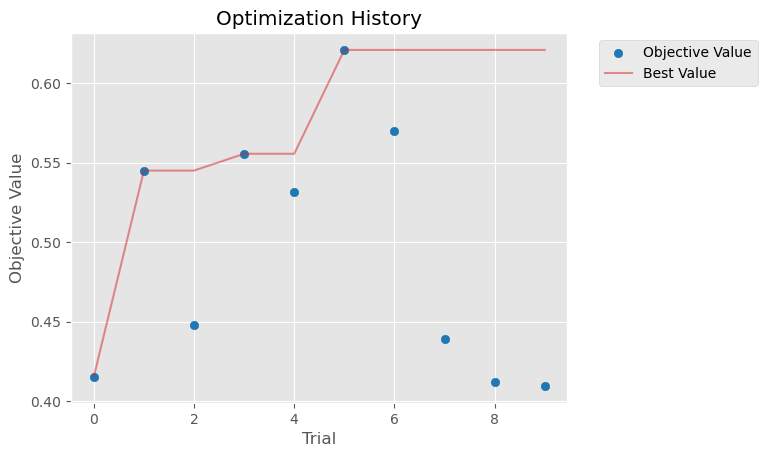

C:\Users\chris\AppData\Local\Temp\ipykernel_19720\2569636288.py:62: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 640x480 with 0 Axes>

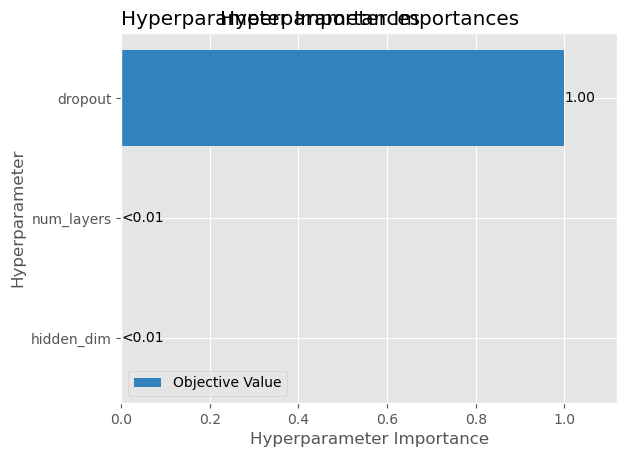

In [26]:
study_rnn = run_optuna_tuning(df_merged, target_cols=["capacity"], n_trials=10)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from scikeras.wrappers import KerasClassifier

def create_cnn_model(vocab_size=10000, max_length=100, embedding_dim=100, 
                     num_filters=128, kernel_size=5, dropout_rate=0.5, dense_units=64):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 sentiment classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_cnn_model, verbose=0)

param_dist = {
    'filters': [32, 64, 128],
    'kernel_size': [3, 5],
    'dense_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'epochs': [10],
    'batch_size': [32]
}

search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                            n_iter=5, cv=3, verbose=1)

search_result = search.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.utils import to_categorical

model = KerasClassifier(build_fn=create_cnn_model, verbose=0)

param_dist = {
    'vocab_size': [10000],
    'max_length': [100],
    'embedding_dim': [50, 100],
    'num_filters': [64, 128],
    'kernel_size': [3, 5],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [32, 64],
    'epochs': [5, 10],
    'batch_size': [32, 64]
}

search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, cv=3, verbose=1)

# X_train should be tokenized and padded, y_train should be one-hot encoded
search_result = search.fit(X_train_seq, y_train_seq)


NameError: name 'X_train_seq' is not defined